In [1]:
import os
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

import botorch
from botorch.acquisition import ExpectedImprovement, NoisyExpectedImprovement,\
    PosteriorMean, UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning

import time
import warnings
from botorch.acquisition.objective import ConstrainedMCObjective
from botorch.test_functions import Hartmann, Ackley, EggHolder, Cosine8, DixonPrice, Griewank, Levy, Powell

from botorch.models import SingleTaskGP, FixedNoiseGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

from scipy.stats.qmc import Sobol

# pose as a maximization problem for all
test_functions = {
    'sinc_plus_2':{
        'function':lambda x: torch.sinc(x + 2.),
        'bounds':torch.tensor([-10., 10.]).unsqueeze(-1)
    }
}
for k in test_functions.keys():
    test_functions[k]['bounds'] = test_functions[k]['bounds'].double()

def initialize_first_batch(bounds, m=3):
    """
    bounds: the range in which we want to generate points.
    m: the power of 2 representing the number of Sobol points to generate.
    """
    d = bounds.shape[1]
    sobol_points = torch.tensor(Sobol(d=d, scramble=False).random_base2(m=m))
    # map each dimension to the bounds
    j = 0
    for i in bounds.T:
        sobol_points.T[j] = (i[1] - i[0]) * sobol_points.T[j] + i[0]
        j += 1
    return sobol_points

def prep_model(models, model_key, X_train, y_train, state_dict=None):
    """
    Initialize model according to specifications from the model dict and training data
    Hotload the params from state_dict to speed up likelihood fitting
    """
    model = models[model_key]['gp'](X_train, y_train, covar_module=models[model_key]['covar'])
    if state_dict is not None:
        model.load_state_dict(state_dict)
        
    mll = models[model_key]['likelihood'](model.likelihood, model)
    return mll, model

def training_loop(test_functions, function_key, 
                  models, model_key, 
                  loops, initialization_count_m=2, q=4):
    """
    Trains specified model on function defined by specified key for specified loop count
    """
    # initialize data
    rv = test_functions[function_key]['function']
    X_train = initialize_first_batch(test_functions[function_key]['bounds'], m=initialization_count_m)
    y_train = rv(X_train)
    if len(y_train.shape) == 1:
        y_train = y_train.unsqueeze(-1)
    mll, model = prep_model(models=models, model_key=model_key, X_train=X_train, y_train=y_train)
    
    # fit generate update loop
    for i in range(loops):
        # reload model
        mll, model = prep_model(models=models, 
            model_key=model_key, 
            X_train=X_train, 
            y_train=y_train,
            state_dict=model.state_dict())
        # fit model and acquisition function
        fit_gpytorch_mll(mll)
        best_value = y_train.max()
        acq = models[model_key]['acq'](model=model, best_f=best_value, maximize=True)

        # generate new points
        candidates, _ = optimize_acqf(
            acq_function=acq,
            bounds=test_functions[function_key]['bounds'],
            q=q,
            num_restarts=20,
            raw_samples=100,  # used for intialization heuristic
        )
        new_y = rv(candidates)
        if len(new_y.shape) == 1:
            new_y = new_y.unsqueeze(-1)
        X_train = torch.cat([X_train, candidates])
        y_train = torch.cat([y_train, new_y])
        best_value = y_train.max()
        
    return mll, model, X_train, y_train, best_value

models = {
    'standard':{
        'gp':SingleTaskGP,
        'likelihood':ExactMarginalLogLikelihood,
        'acq':qExpectedImprovement,
        'covar':None # Matern by default
    }
}

In [2]:
function_key = 'sinc_plus_2'
model_key = 'standard'
initialization_count_m = 2
q = 4
loops=4

x_linspace = torch.linspace(-10, 10, 1000)

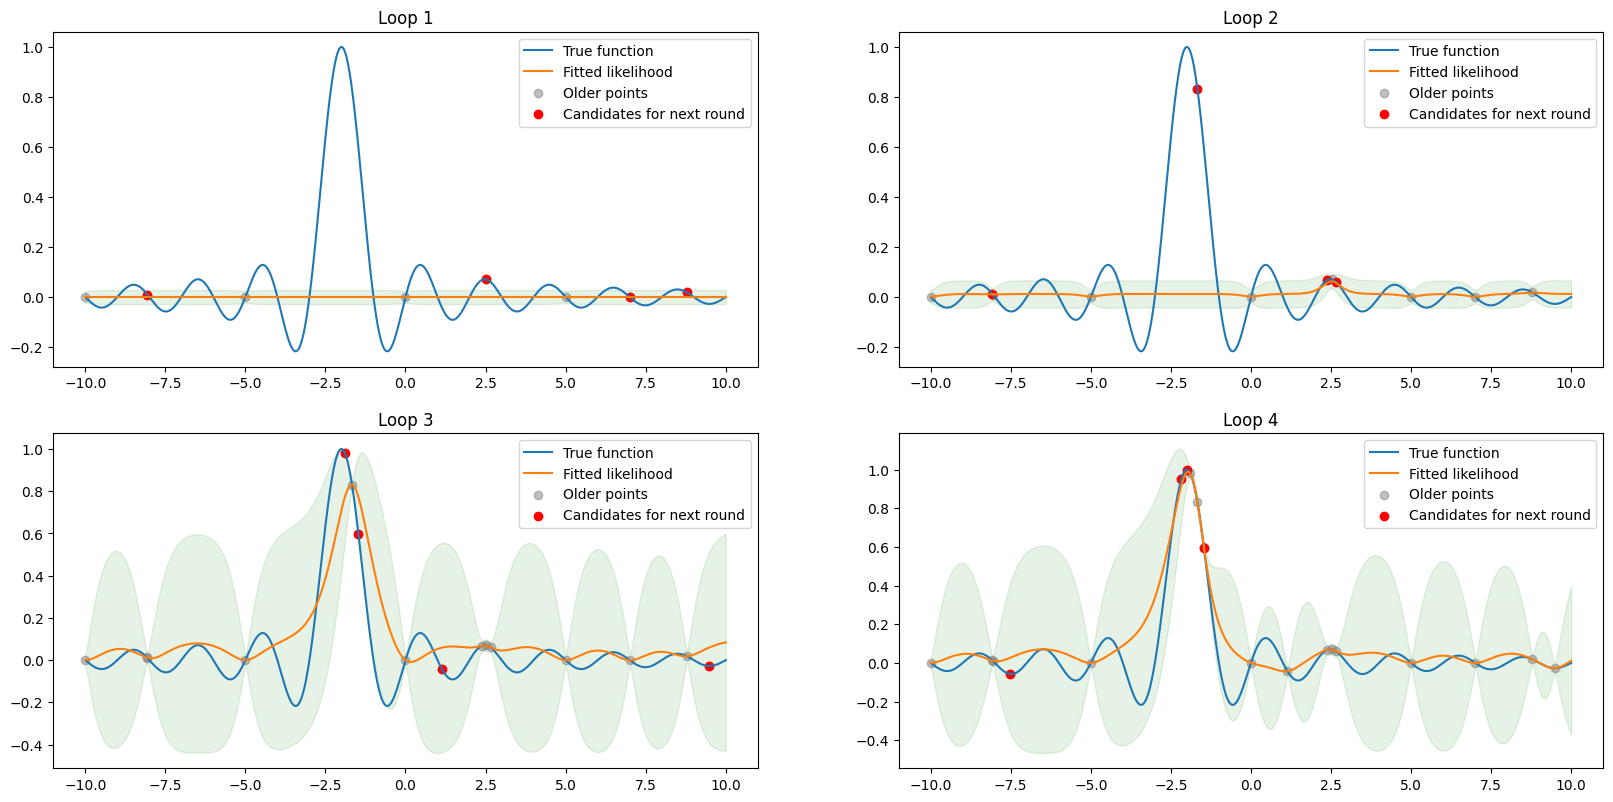

In [3]:
# initialize data
rv = test_functions[function_key]['function']
X_train = initialize_first_batch(test_functions[function_key]['bounds'], m=initialization_count_m)
y_train = rv(X_train)
if len(y_train.shape) == 1:
    y_train = y_train.unsqueeze(-1)
mll, model = prep_model(models=models, model_key=model_key, X_train=X_train, y_train=y_train)

fig = plt.figure(figsize=(20,20))

# fit generate update loop
for i in range(loops):
    # reload model
    mll, model = prep_model(models=models, 
        model_key=model_key, 
        X_train=X_train, 
        y_train=y_train,
        state_dict=model.state_dict())
    # fit model and acquisition function
    fit_gpytorch_mll(mll)
    best_value = y_train.max()
    acq = models[model_key]['acq'](model=model, best_f=best_value, maximize=True)

    # generate new points
    candidates, _ = optimize_acqf(
        acq_function=acq,
        bounds=test_functions[function_key]['bounds'],
        q=q,
        num_restarts=10,
        raw_samples=10,  # used for intialization heuristic
    )
    new_y = rv(candidates)
    if len(new_y.shape) == 1:
        new_y = new_y.unsqueeze(-1)
    X_train = torch.cat([X_train, candidates])
    y_train = torch.cat([y_train, new_y])
    best_value = y_train.max()

    plt.subplot(4,2,i+1)
    # plot true sinc function
    plt.plot(x_linspace, test_functions['sinc_plus_2']['function'](x_linspace), label='True function')
    # plot fitted Gaussian likelihood
    with torch.no_grad():
        preds = model.likelihood(model(x_linspace))
        plt.plot(x_linspace, preds.mean, label='Fitted likelihood')
        plt.fill_between(x_linspace, 
                         (preds.mean - 2 * preds.stddev), 
                         (preds.mean + 2 * preds.stddev), 
                         color='g', 
                         alpha=.1)
    # plot historical candidates
    plt.scatter(X_train, y_train, c='gray', alpha=0.5, label='Older points')
    # plot next candidate point suggestions
    plt.scatter(candidates, new_y, c='r', label='Candidates for next round')
    plt.title('Loop {}'.format(i+1))
    plt.legend()

In [4]:
function_key = 'sinc_plus_2'
model_key = 'standard'
initialization_count_m = 2
q = 1
loops = 16

x_linspace = torch.linspace(-10, 10, 1000)

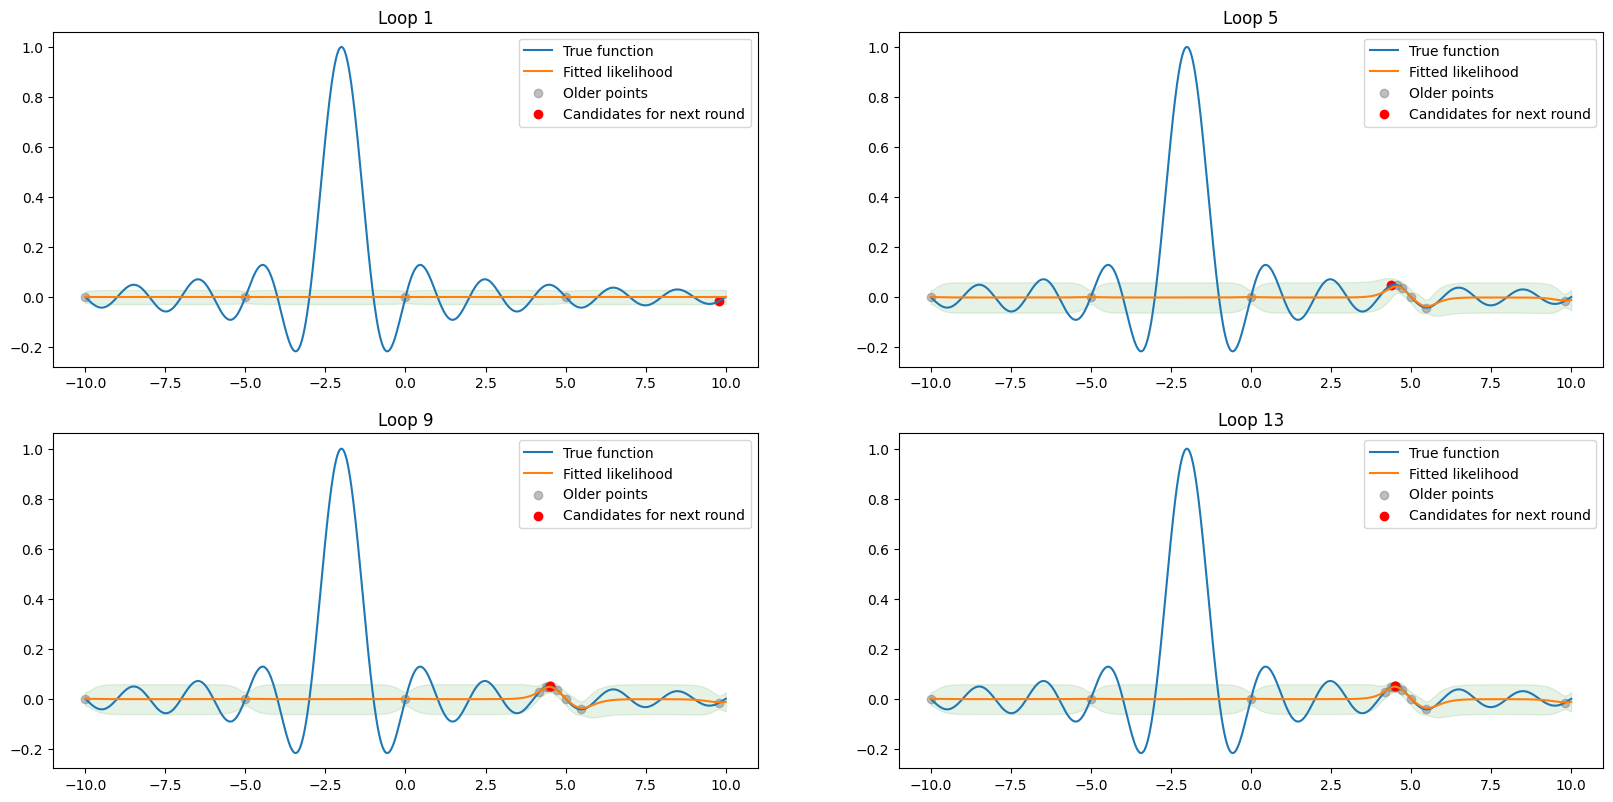

In [5]:
# initialize data
rv = test_functions[function_key]['function']
X_train = initialize_first_batch(test_functions[function_key]['bounds'], m=initialization_count_m)
y_train = rv(X_train)
if len(y_train.shape) == 1:
    y_train = y_train.unsqueeze(-1)
mll, model = prep_model(models=models, model_key=model_key, X_train=X_train, y_train=y_train)

fig = plt.figure(figsize=(20,20))

# fit generate update loop
for i in range(loops):
    # reload model
    mll, model = prep_model(models=models, 
        model_key=model_key, 
        X_train=X_train, 
        y_train=y_train,
        state_dict=model.state_dict())
    # fit model and acquisition function
    fit_gpytorch_mll(mll)
    best_value = y_train.max()
    acq = models[model_key]['acq'](model=model, best_f=best_value, maximize=True)

    # generate new points
    candidates, _ = optimize_acqf(
        acq_function=acq,
        bounds=test_functions[function_key]['bounds'],
        q=q,
        num_restarts=20,
        raw_samples=100,  # used for intialization heuristic
    )
    new_y = rv(candidates)
    if len(new_y.shape) == 1:
        new_y = new_y.unsqueeze(-1)
    X_train = torch.cat([X_train, candidates])
    y_train = torch.cat([y_train, new_y])
    best_value = y_train.max()

    if (i % 4) == 0:
        plt.subplot(4,2,(i // 4)+1)
        # plot true sinc function
        plt.plot(x_linspace, test_functions['sinc_plus_2']['function'](x_linspace), label='True function')
        # plot fitted Gaussian likelihood
        with torch.no_grad():
            preds = model.likelihood(model(x_linspace))
            plt.plot(x_linspace, preds.mean, label='Fitted likelihood')
            plt.fill_between(x_linspace, 
                             (preds.mean - 2 * preds.stddev), 
                             (preds.mean + 2 * preds.stddev), 
                             color='g', 
                             alpha=.1)
        # plot historical candidates
        plt.scatter(X_train, y_train, c='gray', alpha=0.5, label='Older points')
        # plot next candidate point suggestions
        plt.scatter(candidates, new_y, c='r', label='Candidates for next round')
        plt.title('Loop {}'.format(i+1))
        plt.legend()